reading the rotate code at 

https://github.com/python-pillow/Pillow/blob/ec40c546d7d38efebcb228745291bd3ba6233196/src/PIL/Image.py#L2340

make a local copy here as a function and see if I can get it to spit out the transform required for the gauge coords

In [2]:
from PIL import Image, ImageDraw, ImageFilter
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def rotate(
    img,
    angle: float,
    resample=Image.BICUBIC,
    expand: int | bool = False,
    center: tuple[float, float] | None = None,
    translate: tuple[int, int] | None = None,
    fillcolor: float | tuple[float, ...] | str | None = None,
) -> Image:
    """
    https://github.com/python-pillow/Pillow/blob/ec40c546d7d38efebcb228745291bd3ba6233196/src/PIL/Image.py#L2340
    edited to return matrix coefficients



    Returns a rotated copy of this image.  This method returns a
    copy of this image, rotated the given number of degrees counter
    clockwise around its centre.

    :param angle: In degrees counter clockwise.
    :param resample: An optional resampling filter.  This can be
       one of :py:data:`Resampling.NEAREST` (use nearest neighbour),
       :py:data:`Resampling.BILINEAR` (linear interpolation in a 2x2
       environment), or :py:data:`Resampling.BICUBIC` (cubic spline
       interpolation in a 4x4 environment). If omitted, or if the image has
       mode "1" or "P", it is set to :py:data:`Resampling.NEAREST`.
       See :ref:`concept-filters`.
    :param expand: Optional expansion flag.  If true, expands the output
       image to make it large enough to hold the entire rotated image.
       If false or omitted, make the output image the same size as the
       input image.  Note that the expand flag assumes rotation around
       the center and no translation.
    :param center: Optional center of rotation (a 2-tuple).  Origin is
       the upper left corner.  Default is the center of the image.
    :param translate: An optional post-rotate translation (a 2-tuple).
    :param fillcolor: An optional color for area outside the rotated image.
    :returns: An :py:class:`~PIL.Image.Image` object.
    """

    angle = angle % 360.0

    # Calculate the affine matrix.  Note that this is the reverse
    # transformation (from destination image to source) because we
    # want to interpolate the (discrete) destination pixel from
    # the local area around the (floating) source pixel.

    # The matrix we actually want (note that it operates from the right):
    # (1, 0, tx)   (1, 0, cx)   ( cos a, sin a, 0)   (1, 0, -cx)
    # (0, 1, ty) * (0, 1, cy) * (-sin a, cos a, 0) * (0, 1, -cy)
    # (0, 0,  1)   (0, 0,  1)   (     0,     0, 1)   (0, 0,   1)

    # The reverse matrix is thus:
    # (1, 0, cx)   ( cos -a, sin -a, 0)   (1, 0, -cx)   (1, 0, -tx)
    # (0, 1, cy) * (-sin -a, cos -a, 0) * (0, 1, -cy) * (0, 1, -ty)
    # (0, 0,  1)   (      0,      0, 1)   (0, 0,   1)   (0, 0,   1)

    # In any case, the final translation may be updated at the end to
    # compensate for the expand flag.

    w, h = img.size

    if translate is None:
        post_trans = (0, 0)
    else:
        post_trans = translate
    if center is None:
        center = (w / 2, h / 2)

    angle = -math.radians(angle)
    matrix = [
        round(math.cos(angle), 15),
        round(math.sin(angle), 15),
        0.0,
        round(-math.sin(angle), 15),
        round(math.cos(angle), 15),
        0.0,
    ]

    def transform(x: float, y: float, matrix: list[float]) -> tuple[float, float]:
        (a, b, c, d, e, f) = matrix
        return a * x + b * y + c, d * x + e * y + f

    matrix[2], matrix[5] = transform(
        -center[0] - post_trans[0], -center[1] - post_trans[1], matrix
    )
    matrix[2] += center[0]
    matrix[5] += center[1]

    if expand:
        # calculate output size
        xx = []
        yy = []
        for x, y in ((0, 0), (w, 0), (w, h), (0, h)):
            transformed_x, transformed_y = transform(x, y, matrix)
            xx.append(transformed_x)
            yy.append(transformed_y)
        nw = math.ceil(max(xx)) - math.floor(min(xx))
        nh = math.ceil(max(yy)) - math.floor(min(yy))

        # We multiply a translation matrix from the right.  Because of its
        # special form, this is the same as taking the image of the
        # translation vector as new translation vector.
        matrix[2], matrix[5] = transform(-(nw - w) / 2.0, -(nh - h) / 2.0, matrix)
        w, h = nw, nh

    return img.transform(
        (w, h), Image.AFFINE, matrix, resample, fillcolor=fillcolor
    ), matrix

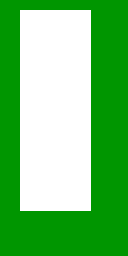

In [4]:
# something gauge block shaped
img = Image.new(mode="RGB", size=(128, 256), color=(0, 150, 0))
draw = ImageDraw.Draw(img)
pa = np.array([(20, 10), (20, 210), (90, 210)])
draw.rectangle((pa[0, 0], pa[0, 1], pa[2, 0], pa[2, 1]), fill="white")
img

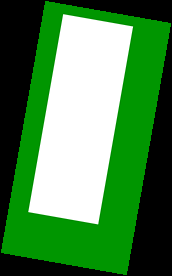

In [17]:
angle_deg = -10.0
phi = np.deg2rad(angle_deg)
img_gb, matrix = rotate(img, angle_deg, expand=True)
img_gb

In [18]:
matrix

[0.984807753012208,
 0.17364817766693,
 -44.656915277086235,
 -0.17364817766693,
 0.984807753012208,
 7.030273363671279]

In [19]:
M1 = np.array(matrix).reshape(2, 3)
M1 = np.vstack((M1, [0, 0, 1]))
M1

array([[  0.98480775,   0.17364818, -44.65691528],
       [ -0.17364818,   0.98480775,   7.03027336],
       [  0.        ,   0.        ,   1.        ]])

In [20]:
X1 = np.hstack((pa, np.ones((pa.shape[0], 1))))
X1

array([[ 20.,  10.,   1.],
       [ 20., 210.,   1.],
       [ 90., 210.,   1.]])

In [21]:
np.dot(M1, X1.T)

array([[-23.22427844,  11.50535709,  80.4418998 ],
       [ 13.40538734, 210.36693794, 198.21156551],
       [  1.        ,   1.        ,   1.        ]])

In [22]:
X2 = np.dot(np.linalg.inv(M1), X1.T)
X2

array([[ 63.15894383,  28.4293083 ,  97.36585101],
       [ 14.15216533, 211.11371593, 223.26908837],
       [  1.        ,   1.        ,   1.        ]])

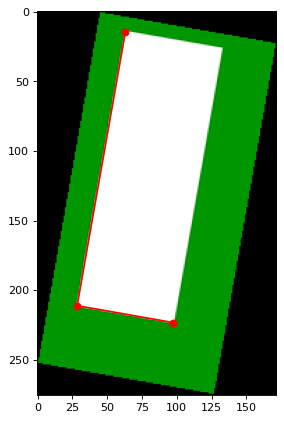

In [23]:
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(np.asarray(img_gb))
axes.axis("image")
axes.plot(X2[0, :], X2[1, :], "r-o")

In [24]:
a = np.arange(8).reshape((2, 4))
a

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [25]:
b = a.T
a, b

(array([[0, 1, 2, 3],
        [4, 5, 6, 7]]),
 array([[0, 4],
        [1, 5],
        [2, 6],
        [3, 7]]))

In [26]:
from plot_helpers import rotate as rotate_pnts

In [27]:
img_gb, pb = rotate_pnts(img, angle_deg, expand=True, points=pa)
pa, pb

(array([[ 20,  10],
        [ 20, 210],
        [ 90, 210]]),
 array([[ 63.15894383,  14.15216533],
        [ 28.4293083 , 211.11371593],
        [ 97.36585101, 223.26908837]]))

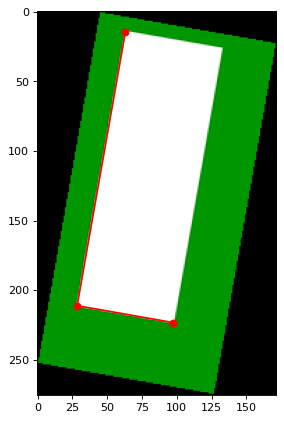

In [28]:
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(np.asarray(img_gb))
axes.axis("image")
axes.plot(pb[:, 0], pb[:, 1], "r-o")